# VQLS Solver Performance Analysis

We test here the VQLS SOLVER in isolation to explore its performance.

Wr first define the system we want to explore

In [44]:
import os
os.environ['EPANET_QUANTUM'] = "/home/nico/QuantumApplicationLab/vitens/EPANET"
os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum/"

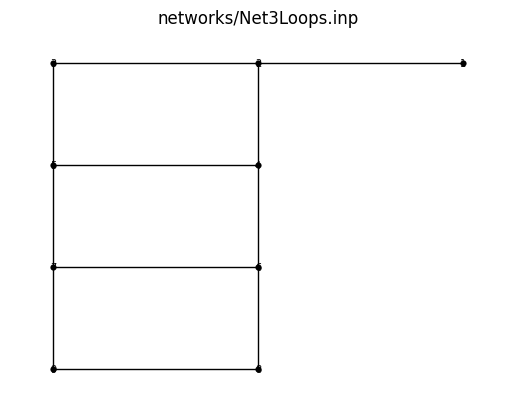

<Axes: title={'center': 'networks/Net3Loops.inp'}>

In [167]:
import wntr
import wntr_quantum

# Create a water network model
# inp_file = 'networks/Net0.inp'
# inp_file = 'networks/Net2Loops_modified.inp'
# inp_file = 'networks/Net1Loops.inp'
inp_file = 'networks/Net3Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

We then solve it with the internal Cholesky solver implemented in WNTR Quantum

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Solving the linear system Ax = b with:
A =  [[ 0.079 -0.04   0.    -0.04   0.     0.     0.     0.   ]
 [-0.04   0.079 -0.04   0.     0.     0.     0.     0.   ]
 [ 0.    -0.04   1.112 -0.197  0.     0.     0.    -0.875]
 [-0.04   0.    -0.197  0.277 -0.04   0.     0.     0.   ]
 [ 0.     0.     0.    -0.04   0.119 -0.04   0.    -0.04 ]
 [ 0.     0.     0.     0.    -0.04   0.137 -0.097  0.   ]
 [ 0.     0.     0.     0.     0.    -0.097  2.636 -1.268]
 [ 0.     0.    -0.875  0.    -0.04   0.    -1.268  2.183]]
b =  [ -2.172  -2.354  -2.937  -1.711  -2.558  -0.911 874.005  -1.098]
x =  [587.843 592.846 657.222 637.618 632.925 657.739 677.261 667.922]
residue =  1.7949679892771277e-13
Solving the linear system Ax = b with:
A =  [[ 0.034 -0.029  0.    -0.005  0.     0.     0.     0.   ]
 [-0.029  0.033 -0.004  0.     0.     0.     0.     0.   ]
 [ 0.    -0.004  0.203 -0.035  0.     0.     

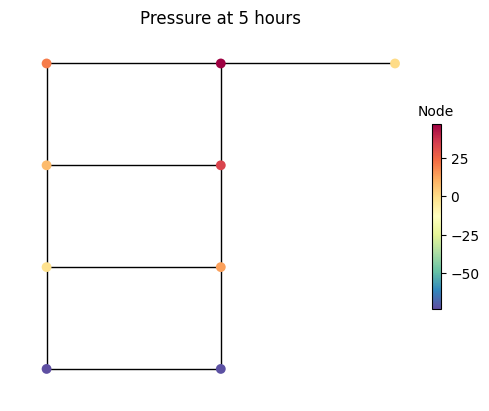

<Axes: title={'center': 'Pressure at 5 hours'}>

In [168]:
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

The last matrix of the Newton Raphson has been stored in the `tmp` directory of EPANET. We can load it to further analyze how VQLS performs on it.

In [169]:
import sys
import os 
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]
util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data 
A, b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

In [170]:
# import scipy.sparse as spsp
import numpy as np
# size = 8
# A = spsp.random(size,size, density = 0.25)
# A=A+A.T
# A.todense()

# b = np.random.rand(size)
np.linalg.cond(A.todense())

181.65907919074067

In [171]:
P  = np.diag(np.sqrt(np.diag(A.todense())))
iP = np.linalg.inv(P)
Q = iP 
QAP = Q @ A @ iP
Qb = Q @ b
np.linalg.cond(Q @ A @ iP)

32.51322133881136

In [172]:
QAP

array([[ 1.   , -0.909,  0.   , -0.063,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.909,  1.   , -0.044,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.044,  1.   , -0.218,  0.   ,  0.   ,  0.   , -0.568],
       [-0.063,  0.   , -0.218,  1.   , -0.754,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.754,  1.   , -0.161,  0.   , -0.037],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.161,  1.   , -0.178,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.178,  1.   , -0.551],
       [ 0.   ,  0.   , -0.568,  0.   , -0.037,  0.   , -0.551,  1.   ]])

In [177]:
from quantum_newton_raphson.vqls_solver import VQLS_SOLVER
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes 
from qiskit_algorithms.optimizers import CG, COBYLA, ADAM, SPSA, AQGD
from qiskit_algorithms.gradients import LinCombEstimatorGradient

# define the ansatz
qc = RealAmplitudes(3, reps=5, entanglement='full')

# define estimator
estimator = Estimator()

# define the solver
vqls = VQLS_SOLVER(
    estimator = estimator,
    ansatz = qc,
    optimizer = [COBYLA(maxiter=500), CG(disp=True, maxiter=50)],
    # gradient = LinCombEstimatorGradient(estimator),
    matrix_decomposition = "symmetric",
    verbose=True
)
# res = vqls.solve(A.todense(),b)

We can solve the system using VQLS

In [178]:
res = vqls(QAP, Qb)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


         Current function value: 0.000002
         Iterations: 50
         Function evaluations: 1824
         Gradient evaluations: 96
[-0.09  -0.091 -0.374 -0.257 -0.232 -0.144 -0.622 -0.562]


We can plot the evoluation of the los function

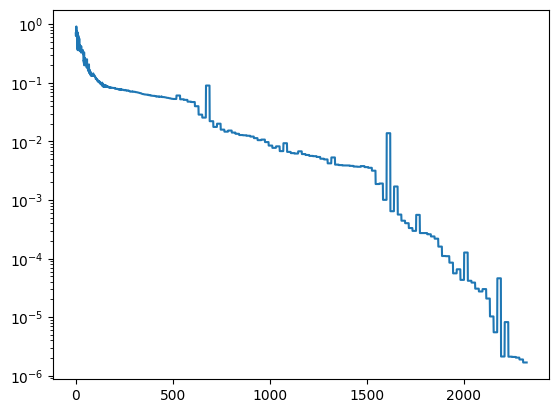

In [179]:
import matplotlib.pyplot as plt
plt.semilogy(res.logger.values)

And plot the vqls solution compared to the LU solution

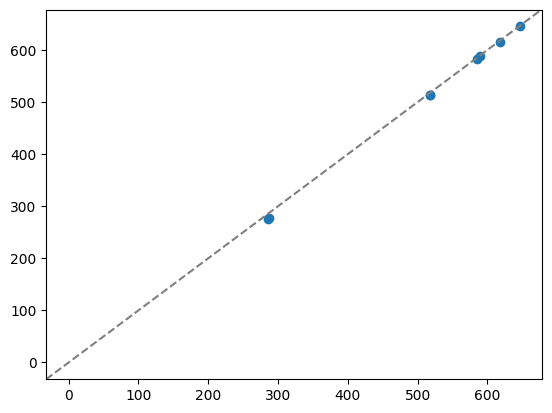

In [180]:
import numpy as np 
ref = np.linalg.solve(A.todense(),b)

plt.scatter(ref, res.solution*np.diag(iP))
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.show()

In [181]:
ref 

array([285.178, 286.915, 584.641, 517.963, 517.401, 589.726, 646.091, 617.627])

In [183]:
res.solution*np.diag(iP)

array([274.82 , 276.581, 582.442, 514.48 , 514.106, 588.294, 645.151, 615.983])

In [91]:
Ad = A.todense()

In [97]:
np.linalg.solve(Ad-0*np.eye(4),b)+0

array([561.597, 628.269, 682.218, 680.56 ])

In [107]:
np.linalg.solve(M@Ad,b)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 8)

In [184]:
from vqls_prototype.matrix_decomposition import PauliDecomposition

In [185]:
p1 = PauliDecomposition(A.todense())

100%|██████████| 64/64 [00:00<00:00, 1937.76it/s]


In [186]:
p2 = PauliDecomposition(QAP)

100%|██████████| 64/64 [00:00<00:00, 1458.92it/s]


In [188]:
len(p1.strings)

28

In [189]:
len(p2.strings)

27

In [190]:
QAP

array([[ 1.   , -0.909,  0.   , -0.063,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.909,  1.   , -0.044,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.044,  1.   , -0.218,  0.   ,  0.   ,  0.   , -0.568],
       [-0.063,  0.   , -0.218,  1.   , -0.754,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.754,  1.   , -0.161,  0.   , -0.037],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.161,  1.   , -0.178,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.178,  1.   , -0.551],
       [ 0.   ,  0.   , -0.568,  0.   , -0.037,  0.   , -0.551,  1.   ]])

In [209]:
from qreorder.classical import ReverseCuthillMcKee, COLAMD, LexicographicBFS
reorder = LexicographicBFS()
idx = reorder.get_ordering(QAP)
idx

[6, 5, 7, 4, 2, 3, 1, 0]

In [210]:
pd3 = PauliDecomposition(QAP[np.ix_(idx,idx)])

100%|██████████| 64/64 [00:00<00:00, 2321.18it/s]


In [211]:
len(pd3.strings)

21

In [212]:
QAP[np.ix_(idx,idx)]

array([[ 1.   , -0.178, -0.551,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.178,  1.   ,  0.   , -0.161,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.551,  0.   ,  1.   , -0.037, -0.568,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.161, -0.037,  1.   ,  0.   , -0.754,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.568,  0.   ,  1.   , -0.218, -0.044,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.754, -0.218,  1.   ,  0.   , -0.063],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.044,  0.   ,  1.   , -0.909],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.063, -0.909,  1.   ]])

In [213]:
reorder = COLAMD()
idx = reorder.get_ordering(QAP)
idx

[0, 1, 3, 2, 4, 7, 5, 6]

In [214]:
pd4 = PauliDecomposition(QAP[np.ix_(idx,idx)])
len(pd4.strings)

100%|██████████| 64/64 [00:00<00:00, 1762.46it/s]


24

In [215]:
QAP[np.ix_(idx,idx)]

array([[ 1.   , -0.909, -0.063,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.909,  1.   ,  0.   , -0.044,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.063,  0.   ,  1.   , -0.218, -0.754,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.044, -0.218,  1.   ,  0.   , -0.568,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.754,  0.   ,  1.   , -0.037, -0.161,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.568, -0.037,  1.   ,  0.   , -0.551],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.161,  0.   ,  1.   , -0.178],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.551, -0.178,  1.   ]])

In [221]:
pd3.strings

['III',
 'IIX',
 'IIZ',
 'IXI',
 'IXZ',
 'IYI',
 'IZX',
 'IZZ',
 'XXI',
 'XXZ',
 'YYI',
 'YYZ',
 'ZII',
 'ZIX',
 'ZIZ',
 'ZXI',
 'ZXZ',
 'ZYI',
 'ZZI',
 'ZZX',
 'ZZZ']

In [222]:
pd4.strings

['III',
 'IIX',
 'IIY',
 'IIZ',
 'IXI',
 'IXZ',
 'IZI',
 'IZX',
 'IZY',
 'IZZ',
 'XXI',
 'XXZ',
 'YYI',
 'YYZ',
 'ZII',
 'ZIX',
 'ZIY',
 'ZIZ',
 'ZXI',
 'ZXZ',
 'ZZI',
 'ZZX',
 'ZZY',
 'ZZZ']

In [234]:
np.sqrt(pd3.coefficients * np.conj(pd3.coefficients))

array([1.000e+00+0.j, 3.355e-01+0.j, 2.776e-17+0.j, 2.050e-01+0.j, 9.272e-02+0.j, 6.939e-18+0.j, 1.375e-01+0.j, 2.776e-17+0.j, 3.304e-01+0.j, 4.639e-02+0.j, 3.304e-01+0.j, 4.639e-02+0.j, 4.163e-17+0.j, 2.279e-01+0.j, 4.163e-17+0.j, 1.514e-01+0.j, 1.022e-01+0.j, 6.939e-18+0.j, 4.163e-17+0.j,
       2.079e-01+0.j, 6.939e-17+0.j])

In [236]:
len(pd3.coefficients[np.absolute(pd3.coefficients)>1e-8])

13

In [237]:
len(pd4.coefficients[np.absolute(pd4.coefficients)>1e-8])

13

In [241]:
len(p2.coefficients[np.absolute(p2.coefficients)>1e-8])

17

In [242]:
len(p1.coefficients[np.absolute(p1.coefficients)>1e-8])

24

In [229]:
from qiskit.quantum_info import SparsePauliOp, Operator
Operator(SparsePauliOp('IIY')).data.imag


array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [243]:
P

array([[0.231, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.229, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.45 , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.351, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.316, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.171, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.676, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.64 ]])

In [244]:
1/P

/tmp/ipykernel_4864/3591649566.py:1: RuntimeWarning: divide by zero encountered in divide
  1/P


array([[4.336,   inf,   inf,   inf,   inf,   inf,   inf,   inf],
       [  inf, 4.359,   inf,   inf,   inf,   inf,   inf,   inf],
       [  inf,   inf, 2.222,   inf,   inf,   inf,   inf,   inf],
       [  inf,   inf,   inf, 2.853,   inf,   inf,   inf,   inf],
       [  inf,   inf,   inf,   inf, 3.169,   inf,   inf,   inf],
       [  inf,   inf,   inf,   inf,   inf, 5.842,   inf,   inf],
       [  inf,   inf,   inf,   inf,   inf,   inf, 1.48 ,   inf],
       [  inf,   inf,   inf,   inf,   inf,   inf,   inf, 1.563]])

In [247]:
np.diag(1./np.diag(P))

array([[4.336, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 4.359, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 2.222, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 2.853, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 3.169, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 5.842, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.48 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.563]])

In [248]:
np.linalg.inv(P)

array([[4.336, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 4.359, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 2.222, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 2.853, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 3.169, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 5.842, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.48 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.563]])